In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
#Parameters


#MACD parameters
n = 9
m = 19
t = 6

#RSI parameters
period = 14

In [17]:
dataimport = pd.read_csv('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/preprocessing/Nifty_50.csv')


dataimport['Date'] = pd.to_datetime(dataimport['Date'])
dataimport.set_index('Date', inplace=True)
data = dataimport.copy()

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

data

,Date,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BPCL.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
0,2011-01-03,83.153633,134.706543,439.091125,259.076141,251.916626,1036.131714,63.653694,45.593979,60.885281,...,240.419800,222.953842,446.352051,92.316086,245.710632,47.525696,139.034042,172.213837,1034.288086,159.698929
1,2011-01-04,83.358696,137.957016,435.507385,255.619690,248.287949,1003.359985,63.260792,45.380741,60.294853,...,233.050705,224.143417,441.225677,93.640793,243.823334,46.894550,145.471405,170.863922,1036.665527,160.227905
2,2011-01-05,83.576599,146.361649,430.650635,259.612366,241.463486,964.553528,62.998871,45.046360,58.357433,...,229.438522,223.297012,446.698883,92.978455,240.893860,45.966370,142.335739,170.083847,1019.882263,160.558502
3,2011-01-06,82.596054,143.900589,427.349915,256.818451,240.533295,931.816956,62.208553,44.052860,57.084274,...,223.406967,228.764465,451.613007,91.902100,236.800064,46.125011,142.589737,167.194855,961.211853,160.789902
4,2011-01-07,80.506813,136.749664,432.772583,250.171555,235.891541,923.922119,59.580208,43.214451,56.918213,...,221.579605,225.721909,440.416199,89.666672,223.504745,44.636559,138.262314,159.387207,939.246277,157.682205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2954,2022-12-26,3714.894043,800.667358,4664.918945,3030.543213,927.753296,3446.755371,6406.478027,1534.191528,307.009796,...,576.057678,983.492615,3111.288574,761.544739,383.604401,101.681297,965.031006,2473.087646,7041.815918,378.757324
2955,2022-12-27,3767.767578,811.693237,4624.833008,3086.621094,931.249695,3484.354980,6477.177246,1536.890015,307.859711,...,580.688599,983.591064,3117.601318,764.049500,392.925354,107.636917,973.273804,2495.465088,7074.865234,384.829407
2956,2022-12-28,3795.803467,804.938599,4569.908691,3097.628418,923.757385,3480.376953,6448.698242,1521.897949,306.065430,...,579.868530,978.526245,3115.305908,766.308716,390.084229,106.523270,979.733032,2571.817383,7021.707520,386.023895
2957,2022-12-29,3808.697266,814.077209,4505.970703,3089.149658,933.597290,3462.862793,6483.351074,1510.903687,308.992950,...,590.239685,983.984436,3126.448486,762.330566,384.700989,108.217957,976.792603,2545.004395,6950.433594,388.960388


In [18]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [19]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
master_macd

,Date,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BPCL.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
0,2011-01-21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,2022-12-26,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2941,2022-12-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2942,2022-12-28,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2943,2022-12-29,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,1


In [20]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

In [21]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
master_rsi

,Date,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BPCL.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
0,2011-01-21,50.464134,42.548163,60.388117,27.809632,44.667616,38.917275,28.740460,29.781734,30.865296,...,42.598853,50.574782,65.291971,39.558000,34.726813,23.053031,42.965012,46.456953,41.843280,34.667113
1,2011-01-24,50.281884,48.264506,78.495844,23.610726,53.277395,37.950380,37.546011,28.752792,38.823405,...,52.931649,50.044359,64.341232,42.813995,35.057707,40.713885,46.381510,51.885867,39.956818,29.018157
2,2011-01-25,43.605094,43.876511,63.702442,21.848926,47.415800,35.854319,30.589172,30.308570,54.952767,...,51.202314,41.427199,56.830146,42.608043,30.880447,44.928813,44.547700,54.202835,42.352690,31.989488
3,2011-01-27,40.738504,40.134098,60.100212,21.908541,47.794956,34.557838,28.015269,26.312249,57.296232,...,48.749863,34.363114,59.967143,43.486444,41.012423,42.151256,36.748035,51.243471,36.938164,29.231777
4,2011-01-28,30.773028,43.629190,54.186547,20.176278,39.773987,30.824893,23.631982,25.885412,55.017968,...,45.545366,28.885458,54.027875,25.285880,33.050769,36.324182,29.813610,43.509477,35.097962,28.782867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,2022-12-26,39.656032,34.114945,52.189411,39.118294,57.054523,40.317384,35.298299,36.812619,43.703770,...,48.241055,47.127288,45.137239,38.619894,30.091788,42.280922,37.780675,34.292891,53.296338,34.015453
2941,2022-12-27,42.981091,37.745675,49.346467,48.764349,58.269490,45.634065,40.657541,37.410703,44.748506,...,50.694801,47.180419,46.011136,40.380529,38.200869,54.786189,40.921609,39.538885,54.767674,42.337870
2942,2022-12-28,44.720456,36.421520,45.675140,50.424712,54.698399,45.175537,39.247303,35.405631,42.936925,...,50.240581,44.692276,45.725921,41.996639,36.799663,52.495828,43.335594,53.252946,51.933683,43.838504
2943,2022-12-29,45.543219,39.513202,41.778430,49.104667,58.311926,43.121194,41.888566,33.967854,46.726452,...,55.652306,47.882121,47.429494,39.943416,34.237159,55.541703,42.484551,49.045693,48.323094,47.458580


In [22]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
prices

,Date,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BPCL.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
0,2011-01-21,81.538620,130.016678,450.455017,240.054657,237.070389,921.606445,56.843491,41.164463,54.514904,...,221.234573,222.061661,467.011200,87.472610,222.978928,42.496700,134.892212,163.782654,973.716125,150.739532
1,2011-01-24,81.487343,132.106247,484.641113,236.219772,244.198822,917.431091,57.945408,40.970615,55.465157,...,229.596161,221.787140,466.066864,87.969368,223.147934,43.826523,135.917892,166.711365,967.772949,146.755707
2,2011-01-25,79.468582,130.155991,468.514679,234.318024,238.939987,908.308167,56.062214,41.086922,58.209824,...,228.139374,216.731445,458.107758,87.927979,218.960266,44.238293,135.263382,168.068314,972.860352,147.747543
3,2011-01-27,78.475227,128.298584,463.752258,234.336090,239.262344,902.554016,55.195133,40.335747,58.740299,...,226.056442,211.126770,463.068695,88.052162,224.565750,43.883900,132.000778,166.557220,955.506470,145.671936
4,2011-01-28,73.931427,129.552322,455.217468,232.447922,230.890564,884.659424,53.420330,40.248516,58.348206,...,223.215286,205.339005,456.099854,82.629097,216.011993,43.029980,127.976158,161.988968,948.897766,145.323242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,2022-12-26,3714.894043,800.667358,4664.918945,3030.543213,927.753296,3446.755371,6406.478027,1534.191528,307.009796,...,576.057678,983.492615,3111.288574,761.544739,383.604401,101.681297,965.031006,2473.087646,7041.815918,378.757324
2941,2022-12-27,3767.767578,811.693237,4624.833008,3086.621094,931.249695,3484.354980,6477.177246,1536.890015,307.859711,...,580.688599,983.591064,3117.601318,764.049500,392.925354,107.636917,973.273804,2495.465088,7074.865234,384.829407
2942,2022-12-28,3795.803467,804.938599,4569.908691,3097.628418,923.757385,3480.376953,6448.698242,1521.897949,306.065430,...,579.868530,978.526245,3115.305908,766.308716,390.084229,106.523270,979.733032,2571.817383,7021.707520,386.023895
2943,2022-12-29,3808.697266,814.077209,4505.970703,3089.149658,933.597290,3462.862793,6483.351074,1510.903687,308.992950,...,590.239685,983.984436,3126.448486,762.330566,384.700989,108.217957,976.792603,2545.004395,6950.433594,388.960388


In [23]:
def get_returns(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_macd.iloc[i,j]==1):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_macd.iloc[i,j]==-1):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            intrade.append(l)
        
        i = i+1

    return returns, intrade

    

In [24]:
returns,intrade = get_returns(master_macd, master_rsi, prices)

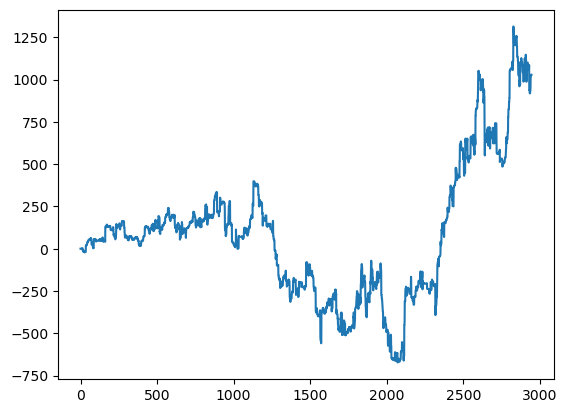

In [25]:
cumulative_returns = np.cumsum(returns)
plt.plot(cumulative_returns)
plt.show()

In [26]:
def get_returns1(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_rsi.iloc[i,j]<30):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_rsi.iloc[i,j]>70):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            intrade.append(l)
        
        i = i+1

    return returns, intrade

In [27]:
returns1,intrade1 = get_returns1(master_macd, master_rsi, prices)

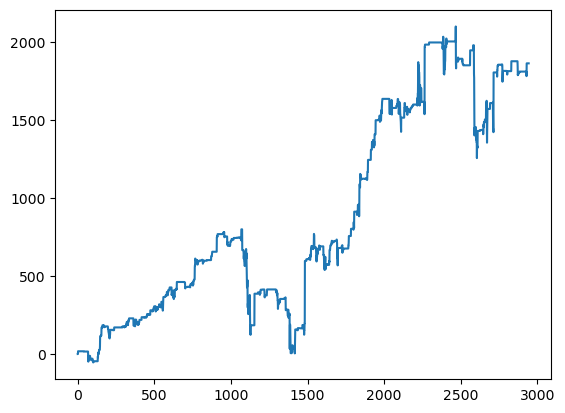

In [28]:
cumulative_returns = np.cumsum(returns1)
plt.plot(cumulative_returns)
plt.show()